In [1]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics

Cloning into 'AMPLify-Feedback'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 442 (delta 48), reused 81 (delta 41), pack-reused 351
Receiving objects: 100% (442/442), 196.07 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (215/215), done.
Updating files: 100% (89/89), done.


In [3]:
generator = tf.keras.models.load_model('/content/AMPLify-Feedback/model_weights/PeptideGenerator_V2.keras')

In [4]:
generator.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 326)]                0         []                            
                                                                                                  
 Input0 (InputLayer)         [(None, 2)]                  0         []                            
                                                                                                  
 Input1Transform (Dense)     (None, 2)                    654       ['Input1[0][0]']              
                                                                                                  
 Concat (Concatenate)        (None, 4)                    0         ['Input0[0][0]',              
                                                                     'Input1Transform[0][0]'

In [5]:
discriminator = tf.keras.models.load_model('/content/AMPLify-Feedback/model_weights/PeptideDiscriminator_V2.keras')

In [6]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 8170)              0         
                                                                 
 Dense0 (Dense)              (None, 512)               4183552   
                                                                 
 Dropout (Dropout)           (None, 512)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               131328    
                                                                 
 Output (Dense)              (None, 1)                 257       
                                                                 
Total params: 4315137 (16.46 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 4315137 (16.46 MB)
_________________________________________________________________


In [14]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [15]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [16]:
oracle.summary()

Model: "MICPredictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 SeqInput (InputLayer)       [(None, 190, 43)]            0         []                            
                                                                                                  
 Conv1D_0 (Conv1D)           (None, 186, 128)             27648     ['SeqInput[0][0]']            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 182, 128)             82048     ['Conv1D_0[0][0]']            
                                                                                                  
 Flatten_0 (Flatten)         (None, 23296)                0         ['Conv1D_1[0][0]']            
                                                                                       

In [17]:
# GAN
def compile_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input0 = layers.Input(shape=(latent_dim,))
    gan_input1 = layers.Input(shape=(326,))
    gan_output = discriminator(generator([gan_input0, gan_input1]))
    gan = tf.keras.Model([gan_input0, gan_input1], gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [18]:
def generate_sequences(generator, latent_dim, num_sequences):
    noise = np.random.normal(0, 1, (num_sequences, latent_dim))
    bacteria = []
    for i in range(num_sequences):
      bacterium = np.zeros(326)
      bacterium[np.random.randint(0, 326)]=1
      bacteria.append([bacterium])
    bacteria = np.concatenate(bacteria, axis=0)
    generated_sequences = generator.predict([noise, bacteria])
    return generated_sequences, bacteria

In [19]:
def fit_gan(generator, discriminator, gan, seq_train, state_train, labels, epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        for i in range(0, seq_train.shape[0], batch_size):
            sequences = seq_train[i:i + batch_size]
            state_train_batch = state_train[i:i + batch_size]
            current_batch_size = sequences.shape[0]

            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(sequences, labels, return_dict=True)
            discriminator.trainable = False

            # Train generator
            noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
            g_loss = gan.train_on_batch([noise, state_train_batch], labels)

            # Print the progress
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size+1}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
            return d_loss, g_loss

In [20]:
def label_from_MIC(prediction, threshold):
  loop_prediction = np.zeros((prediction.shape[0], 1))
  for i in range (prediction.shape[0]):
    if prediction[i] < threshold:
      loop_prediction[i] = 1
  return loop_prediction

In [24]:
def RL_loop(generator, discriminator, gan, oracle, num_sequences, epochs):
  d_loss, d_accuracy, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train  = [], [], [], [], [], [], []

  MIC_threshold = math.log(100,2)
  for i in range (n_iter_max) :
    sequences, bacteria = generate_sequences(generator, latent_dim, num_sequences)
    prediction = oracle.predict([sequences, bacteria])
    average_mic_train += [np.mean(prediction)]
    min_mic_train += [np.min(prediction)]
    max_mic_train += [np.max(prediction)]
    median_mic_train += [np.median(prediction)]
    #MIC_threshold = np.quantile(prediction, 0.75)
    #average_mic_test = validation()
    loop_prediction = label_from_MIC(prediction, MIC_threshold)
    d_results, g_results = fit_gan(generator, discriminator, gan, sequences, bacteria, loop_prediction, epochs=epochs, batch_size=num_sequences, latent_dim=latent_dim)
    d_loss += [d_results['loss']]
    d_accuracy += [d_results['accuracy']]
    g_loss += [g_results]
  return d_loss, d_accuracy, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train

In [27]:
def display(parameters):
  for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
  plt.legend(loc = "upper right")
  plt.ylabel("Value")
  plt.xlabel("Iteration index")
  plt.title("Performances with the feedback loop")
  plt.show()

7/7 [==============================] - 1s 64ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 2.218815326690674, 'accuracy': 0.4449999928474426}, Generator Loss: 2.305250644683838
7/7 [==============================] - 0s 49ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 2.1153976917266846, 'accuracy': 0.5049999952316284}, Generator Loss: 2.2272448539733887
7/7 [==============================] - 0s 53ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 2.2237625122070312, 'accuracy': 0.4699999988079071}, Generator Loss: 1.899430513381958
7/7 [==============================] - 0s 49ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 1.7949246168136597, 'accuracy': 0.5649999976158142}, Generator Loss: 1.8953633308410645
7/7 [==============================] - 1s 85ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 1.845723271369934, 'accuracy': 0.5450000166893005}, Generator Loss: 1.5798821449279785
7/7 [==============================] - 0s 49ms/step
Ep

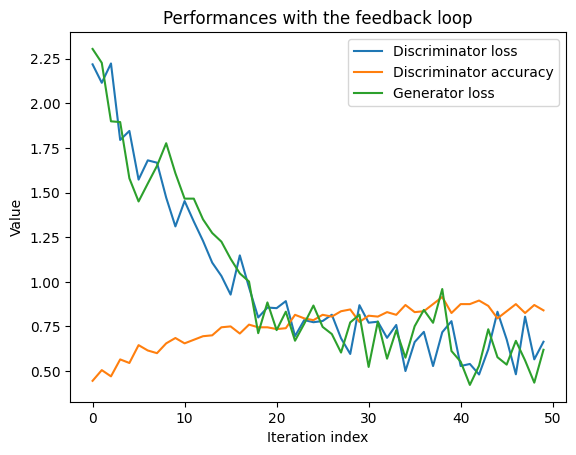

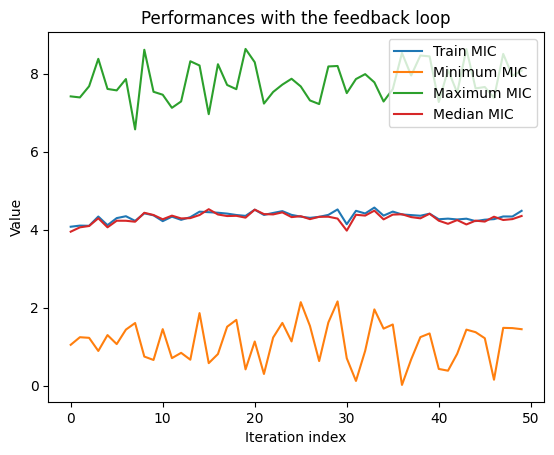

In [28]:
latent_dim = 2
num_sequences = 200
n_iter_max = 50
epochs = 10

gan = compile_gan(generator, discriminator) #build the model
d_loss, d_accuracy, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train = RL_loop(generator, discriminator, gan, oracle, num_sequences, epochs) #train the loop
display({"Discriminator loss" : d_loss, "Discriminator accuracy" : d_accuracy, "Generator loss" : g_loss})
display({"Train MIC" : average_mic_train, "Minimum MIC" : min_mic_train, "Maximum MIC" : max_mic_train, "Median MIC" : median_mic_train})